# This program was written by Angelica Sharma

1. Generate a datatable with 2 columns: one with gene pairs, and one with the final, average weight, given all 7 normalized factors

NOTE: The approach below is not very efficient

This is for finding a specific gene pair in our original datatable, with all values

In [ ]:
import datatable as dt
import os

folder_path = 'C:/Users/angel/final_table_gene_data'  # Replace with the actual folder path

print("Reading CSV files...")

# Iterate through each file in the folder
for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    print("Processing file:", file_path)
    
    # Read the file into a datatable
    df = dt.fread(file_path)

    # Iterate through each row
    for i in range(df.nrows):
        gene_pair = df[i, 'GenePair']  # Get the gene pair
        genes = gene_pair.split(',')  # Split the gene pair string into individual genes
        # Check each gene individually
        if 'ZNF76' in genes and 'TMEM240' in genes:
            print(df[i, :])  # Print the entire row
            break  # Exit the loop after printing the row

In [ ]:
import datatable as dt
import os

folder_path = 'C:/Users/angel/final_table_gene_data'  # Replace with the actual folder path

print("Reading CSV files...")

# Initialize an empty frame to store the combined data
combined_data = dt.Frame(GenePair=[], AverageWeight=[])

# Iterate through each file in the folder
for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    print("Processing file:", file_path)
    
    # Read the file into a datatable
    df = dt.fread(file_path)

    # Iterate through each row
    for i in range(df.nrows):
        gene_pair = df[i, 'GenePair']  # Get the gene pair
        
        # Calculate the average weight for the row
        avg_weight = (df[i, 'Gene Regularatory Weight'] + df[i, 'Shared Protein Domain Weight'] + df[i, 'Genetic Interaction Weight'] + df[i, 'Co-localization Weight'] + df[i, 'Protein-Protein Weight'] + df[i, 'Pathway Weight'] + df[i, 'Co-expression Weight']) / 7
        
        # Append the gene pair and average weight to the combined_data frame
        combined_data.rbind(dt.Frame(GenePair=[gene_pair], AverageWeight=[avg_weight]))
        
    print(combined_data)
    print("Finished analyzing:", file_path)

# Save the combined data to a new file
combined_data.to_csv('averaged_gene_data.csv')

print("Done. Calculating the average weights...")


In [ ]:
# Create a box plot and determine cutoff - determine how many pairs we reduce based on cutoff
# Analyze given disease-related genes and check which genes in my data has a significant amount of correlation, if so add to set of genes
# With new, reduced set of genes, create the similarity matrix & perform GLASSO

Reading CSV file...
Computing box plot...
Generating box plot...


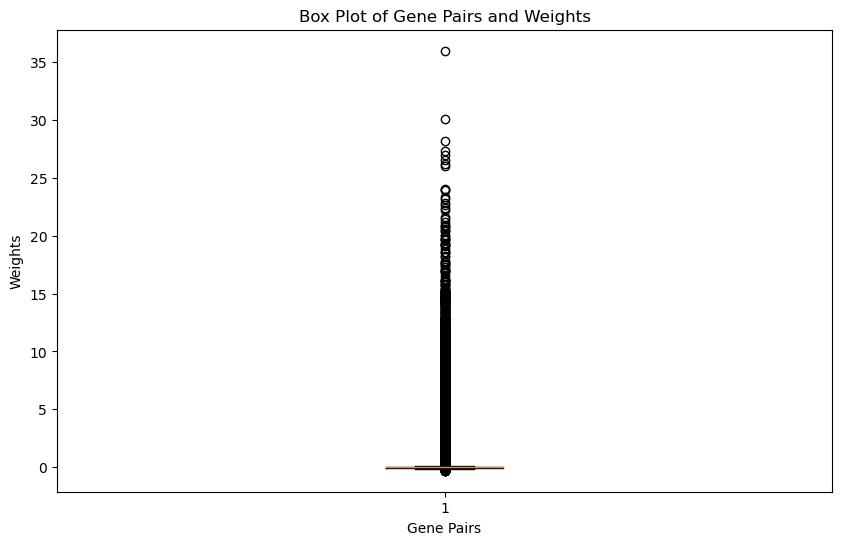

In [3]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

print("Reading CSV file...")
# Read the CSV file using Dask DataFrame
df = dd.read_csv('averaged_gene_data.csv')

print("Computing box plot...")
# Compute the required column for the box plot
weights = df['AverageWeight'].compute()

Generating box plot...


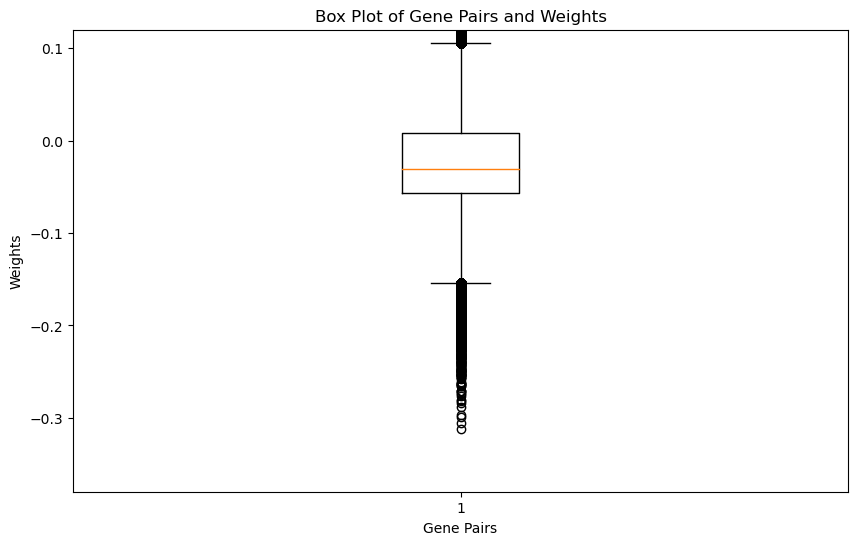

In [10]:
print("Generating box plot...")
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
plt.ylim(-.38, .12)
plt.boxplot(weights)
plt.xlabel('Gene Pairs')
plt.ylabel('Weights')
plt.title('Box Plot of Gene Pairs and Weights')
plt.show()

In [ ]:
import matplotlib.cbook as cbook

# Get the statistics from the box plot
stats = cbook.boxplot_stats(df['AverageWeight'])

In [12]:
# Print the statistics for each box plot element
for element in stats:
    print("Statistics for Box Plot Element:")
    print(" - Median:", element['med'])
    print(" - 1st Quartile:", element['q1'])
    print(" - 3rd Quartile:", element['q3'])
    print(" - Lower Whisker:", element['whislo'])
    print(" - Upper Whisker:", element['whishi'])
    print(" - Outliers:", element['fliers'])
    print()

Statistics for Box Plot Element:
 - Median: -0.0305408664837471
 - 1st Quartile: -0.0566052224059068
 - 3rd Quartile: 0.0084013917680755
 - Lower Whisker: -0.1541149537373869
 - Upper Whisker: 0.1059107555752142
 - Outliers: [-0.18382611 -0.17117044 -0.18532288 ...  0.23771272  0.12451351
  0.35852196]



In [42]:
import pandas as pd

print("Reading CSV file...")
# Read the CSV file using Dask DataFrame
df = dd.read_csv('averaged_gene_data.csv')

print("Computing...")
# Compute the required column for the box plot
weights = df['AverageWeight'].compute()

# Calculate the 97th percentile using Pandas
percentile_95 = weights.quantile(0.95)

# Printing the 97th percentile cutoff
print("95th Percentile Cutoff:", percentile_95)

Reading CSV file...
Computing...
95th Percentile Cutoff: 0.1667491852774178


In [43]:
import dask.dataframe as dd

print("Reading original datatable...")
# Read the original datatable
datatable = dd.read_csv('averaged_gene_data.csv')

print("Filtering datatable based on weights condition...")
# Filter the datatable based on the weights condition
cutoff = 0.1667491852774178
filtered_df = datatable[datatable['AverageWeight'] >= cutoff]

print("Specifying CSV file path...")
# Specify the output CSV file path
output_path = 'filtered_gene_data.csv'

print("Writing the filtered datatable to a CSV file...")
# Write the filtered datatable to a CSV file
filtered_df.to_csv(output_path, index=False, single_file=True)

Reading original datatable...
Filtering datatable based on weights condition...
Specifying CSV file path...
Writing the filtered datatable to a CSV file...


['C:\\Users\\angel\\filtered_gene_data.csv']

In [44]:
import dask.dataframe as dd
from dask.distributed import Client

print("Reading Dask Datatable...")
# Assuming you already have a Dask DataTable called 'dt'
dt = dd.read_csv('filtered_gene_data.csv')

def split_gene_pairs(df):
    df[['Gene1', 'Gene2']] = df['GenePair'].str.split(',', expand=True)
    return df[['Gene1', 'Gene2', 'AverageWeight']]

print("Calling map_partitions...")
# Provide the metadata of the resulting DataFrame
meta = ('Gene1', 'object'), ('Gene2', 'object'), ('AverageWeight', 'object')

# Use map_partitions to split the gene pairs and create new columns
new_dt = dt.map_partitions(split_gene_pairs, meta=meta)

print(new_dt.head())

print("Storing in CSV file...")
# Store the DataTable as a CSV file
new_dt.to_csv('filtered_separated_genes.csv', index=False, single_file=True)

Reading Dask Datatable...
Calling map_partitions...
      Gene1  Gene2  AverageWeight
0   SLC48A1  ASCC2       0.327511
1   SLC48A1   PLD3       0.220590
2    SLC4A1   GYPC       0.769880
3    SLC4A1  ITLN1       0.575027
4  SLC4A1AP   NFU1       0.960285
Storing in CSV file...


['C:\\Users\\angel\\filtered_separated_genes.csv']

In [ ]:
import sys
import re

# Specify the file path
file_path = "genemap2.txt"

gene2map_gene_list = []

# Open the file and read its contents line by line
with open(file_path, 'r') as file:
    for line in file:

        # Skip comments
        if line.startswith('#'):
            continue

        # Strip trailing new line
        line = line.strip('\n')

        # Get the values
        valueList = line.split('\t')

        # Get the fields
        geneSymbol = valueList[8]
        phenotypeString = valueList[12]

        # Skip empty phenotypes
        if not phenotypeString:
            continue
        if not geneSymbol:
            continue
        gene2map_gene_list.append(geneSymbol)
        
%store gene2map_gene_list
print(gene2map_gene_list)

In [ ]:
import dask.dataframe as dd
import time
import dask
import dill

#Creating a dictionary that maps each gene to the correlated genes found in our datatable
#This allows multiple processes to access and update the dictionary concurrently.

first_degree_genes = dict()
%store -r gene2map_gene_list

def findGene(specific_gene, datatable):
    def merge_genes(df, gene):
        df['Merged'] = df.apply(lambda row: row['Gene1'] if row['Gene2'] == gene else row['Gene2'], axis=1)
        return df

    output = datatable.loc[(datatable["Gene1"].isin([specific_gene])) | (datatable["Gene2"].isin([specific_gene]))]
    first_row = output.head(n = 1)
    is_empty = first_row.empty
    if(is_empty):
        return None
    merged_dt = output.map_partitions(merge_genes, specific_gene)
    merged_dt = merged_dt[['Merged', 'AverageWeight']]
    elapsed_time = time.time() - start
    return merged_dt

datatable = dd.read_csv('filtered_separated_genes.csv')
length = len(gene2map_gene_list)
i = 0

start = time.time()
for gene in gene2map_gene_list:
    
    result = findGene(gene, datatable)
    # Print the result
    if not result is None:
        first_degree_genes[gene] = result
    i += 1
    if(i % 100 == 0):
        elapsed_time = time.time() - start
        print("Progress: {}/{}".format(i, length))
        print("Elapsed Time: {:.2f} seconds".format(elapsed_time))
        start = time.time()
print("Done.")

# Save the dictionary to a file using dill
with open('dataframes.pkl', 'wb') as f:
    dill.dump(first_degree_genes, f)


In [ ]:
import dask.dataframe as dd
import pandas as pd

list_dfs = list(first_degree_genes.values())
length = len(first_degree_genes.keys())
number_genes = 5

genes_df = list_dfs[0]
genes_df = genes_df.sort_values(by='AverageWeight', ascending=False)
genes_df = genes_df.head(number_genes)
genes_df = genes_df.loc[:, ['Merged']]

i = 0
# Iterate through each dataframe in the dictionary
for dataframe in list_dfs[1:]:
    
    # Sort the dataframe by the average values in descending order
    dataframe = dataframe.sort_values(by='AverageWeight', ascending=False)
    # Get the top 10 genes from the sorted dataframe
    top_genes = dataframe.head(number_genes)
    # Append the genes column from the dataframe to the genes_df
    genes_df = dd.concat([genes_df, top_genes[['Merged']]])
    genes_df = genes_df.drop_duplicates()
    
    i += 1
    if(i % 100 == 0):
        print("Progress: {}/{}".format(i, length))

set_genes_2 = set(genes_df['Merged'])

%store set_genes_2
print(set_genes_2)


In [64]:
print(len(set_genes_2))

10232


In [110]:
with open('dataframes.pkl', 'rb') as f:
    loaded_dict = dill.load(f)

In [9]:
%store -r set_genes_2
print(len(set_genes_2))

10232


In [1]:
%store -r set_genes_2
print((set_genes_2))

{'SLC17A9', 'CHGA', 'SLC30A5', 'PYROXD1', 'NIPBL', 'LZTFL1', 'LILRB5', 'QDPR', 'FGB', 'CALR', 'FAM170A', 'DLG3', 'GTF2I', 'RIOX1', 'LCA5L', 'EHD1', 'WNT10A', 'BARHL2', 'MLC1', 'TTC38', 'IMPDH1', 'OMD', 'DSG1', 'MS4A7', 'WDR81', 'PWP2', 'SLC33A1', 'TPRG1L', 'IDH3G', 'PNKP', 'C4orf48', 'TENT5C', 'DPP4', 'TMPRSS11E', 'TRMT5', 'CCAR2', 'CELF2', 'RPL34', 'SELENBP1', 'PMP22', 'NADK', 'IL17RB', 'KCNH5', 'GNA13', 'EPGN', 'IGIP', 'CHIT1', 'PUS7L', 'PRPS2', 'NDNF', 'ROMO1', 'POMC', 'ESCO1', 'DAZ1', 'RB1', 'ICAM3', 'ZIC4', 'AKR1C1', 'TBCA', 'ZBTB11', 'MCTP1', 'CHAF1A', 'CHGB', 'PVRIG', 'ATXN7L3', 'MYMX', 'IL1R2', 'E2F4', 'ITGB7', 'GNAQ', 'MKS1', 'PSMD12', 'PABIR2', 'HMGB1', 'CACNB3', 'COPS2', 'MED12', 'MLIP', 'THNSL1', 'GMIP', 'MB', 'SPTA1', 'DCP1B', 'SSX3', 'POLR3G', 'OR8B12', 'TLR5', 'GLG1', 'SLC28A2', 'SCCPDH', 'PHB1', 'KDSR', 'MT3', 'SLC6A7', 'CDK12', 'RIBC2', 'SERPINA10', 'ZNF618', 'SF3B5', 'DPY19L2', 'URB2', 'HMCN2', 'THUMPD3', 'SCN7A', 'ZCCHC14', 'ATPSCKMT', 'TMEM262', 'CAPSL', 'SLCO6A1', 

In [ ]:
import numpy as np
import pandas as pd

# Load the data from the CSV file
print("Reading datafile...")
data = pd.read_csv('filtered_separated_genes.csv')

# List of genes to include in matrix
%store -r set_genes_2           

# Filtering data
print("Filtering data...")
filtered_data = data[data['Gene1'].isin(set_genes_2) & data['Gene2'].isin(set_genes_2)]
         
# Create a dictionary to map gene names to indices
print("Creating dictionary...")
gene_indices_dict = {gene: index for index, gene in enumerate(set_genes_2)}
                   
%store gene_indices_dict
print(gene_indices_dict)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

column_min = filtered_data['AverageWeight'].min()
column_max = filtered_data['AverageWeight'].max()

print("Minimum value:", column_min)
print("Maximum value:", column_max)

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Normalize the column
filtered_data['normalized_weight'] = scaler.fit_transform(filtered_data[['AverageWeight']])

In [54]:
print(filtered_data)
column_min = filtered_data['normalized_weight'].min()
column_max = filtered_data['normalized_weight'].max()

print("Minimum value:", column_min)
print("Maximum value:", column_max)

%store filtered_data

            Gene1   Gene2  AverageWeight  normalized_weight
2          SLC4A1    GYPC       0.769880           0.020160
3          SLC4A1   ITLN1       0.575027           0.013647
4        SLC4A1AP    NFU1       0.960285           0.026524
5          SLC4A2  ATP5MF       0.184111           0.000580
7         SLC52A2   HYOU1       0.958383           0.026460
...           ...     ...            ...                ...
2356100   TNFSF11   CNGA3       0.296690           0.004343
2356101   TNFSF13     MR1       0.641996           0.015885
2356102    TNFSF4  TRMT12       0.166939           0.000006
2356105    TNFSF9  POU3F1       0.172457           0.000191
2356109      TNK1    CA14       0.175501           0.000293

[1197565 rows x 4 columns]
Minimum value: 0.0
Maximum value: 0.9999999999999999
Stored 'filtered_data' (DataFrame)


In [4]:
import pandas as pd
import numpy as np

%store -r filtered_data
%store -r set_genes_2
%store -r gene_indices_dict

print("Initializing similarity matrix...")
# Initialize the similarity matrix with zeros
similarity_matrix = np.zeros((len(set_genes_2), len(set_genes_2)))

print("Filling in matrix...")

# Fill in the similarity matrix
for _, row in filtered_data.iterrows():
    gene1 = row['Gene1']
    gene2 = row['Gene2']
    weight = row['normalized_weight']
    i = gene_indices_dict[gene1]
    j = gene_indices_dict[gene2]
    similarity_matrix[i, j] = weight
    similarity_matrix[j, i] = weight  # Since it's a similarity matrix, set both (i, j) and (j, i) elements

length = len(similarity_matrix)
for i in range(length):
    for j in range(length):
        if i == j:  # Check if element lies on the diagonal
            similarity_matrix[i][j] = 1  # Replace diagonal element with 1
            
print("Done.")
%store similarity_matrix
# Print the similarity matrix
print(similarity_matrix)


Initializing similarity matrix...
Filling in matrix...
Done.
Stored 'similarity_matrix' (ndarray)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
similarity_matrix_df = pd.DataFrame(similarity_matrix, columns=cols, index=cols)
print(similarity_matrix_df)
similarity_matrix_df.to_csv('matrix_1.txt', sep='\t', index=False)

Constructing adjacency matrix...
Creating graph...
Assigning gene names as labels to each node...
Drawing the graph...
Assigning weights as labels to the edges...
Drawing edge labels...
Saving graph...


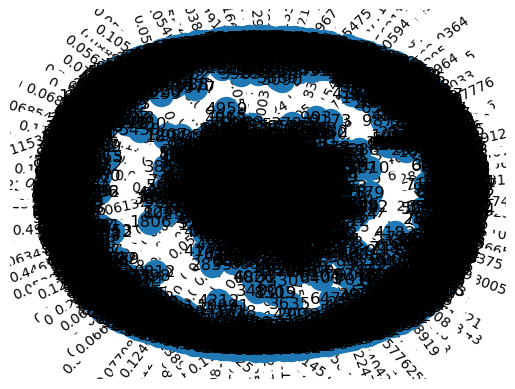

In [35]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


%store -r gene_indices_dict

# Assuming you have your similarity matrix stored in a variable called 'similarity_matrix'
# Assuming you have a dictionary that maps gene names to their indices called 'gene_dict'

print("Constructing adjacency matrix...")
# Construct an adjacency matrix from the similarity matrix
adjacency_matrix = np.where((similarity_matrix > 0.05) & (similarity_matrix < 1), similarity_matrix, 0)

print("Creating graph...")
# Create a graph from the adjacency matrix
graph = nx.from_numpy_matrix(adjacency_matrix)

print("Assigning gene names as labels to each node...")
# Assign gene names as labels to each node in the graph
node_labels = {index: gene_name for gene_name, index in gene_indices_dict.items()}
nx.set_node_attributes(graph, node_labels, 'label')

print("Drawing the graph...")
# Draw the graph
# Create a new figure and axis for the plot
fig, ax = plt.subplots()

# Apply the Spring layout algorithm to space out the nodes
pos = nx.spring_layout(graph)

# Draw the graph with the spaced out nodes
nx.draw(graph, pos=pos, with_labels=True, ax=ax)

print("Assigning weights as labels to the edges...")
# Assign weights as labels to the edges
edge_labels = {(u, v): weight for u, v, weight in graph.edges(data='weight') if weight > 0 and weight < 1}
nx.set_edge_attributes(graph, edge_labels, 'weight')

print("Drawing edge labels...")
# Draw edge labels
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=edge_labels)

print("Saving graph...")
# Save the graph as a GraphML file
nx.write_graphml(graph, 'graph_file.graphml')


In [ ]:
# Pick correct MCL size arbitrarily for now
# For each cluster, do gene ontology enrichment analysis